In [1]:
# Import necessary packages
import numpy as np
import re
import tensorflow as tf

In [2]:
print(tf.__version__)

2.1.0


In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## build a sentiment analysis model via Tf 2.1 and Keras

1. Data import, cleaning
2. Tokenize, sequence and padding the texts (preprocessing)
3. Model define
4. Train and fine-tune the model
5. Make predictions
6. Save the model


### Step 1. Dataset preparation

Load dataset and remove the spaces at the beginning and at the end of the string for all elements

In [4]:
positive_examples = list(open('rt-polarity.pos', 'r').readlines())
positive_examples = [s.strip() for s in positive_examples]

In [5]:
negative_examples = list(open('rt-polarity.neg', 'r').readlines())
negative_examples = [s.strip() for s in negative_examples]

In [6]:
def clean_str(string):
    """
    Clean the text data using the same code as the original paper
    from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    :param string: input string to process
    :return: a sentence with lower representation and delete spaces
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

In [7]:
# clean strings
x_text = positive_examples + negative_examples
x_text = [clean_str(sent) for sent in x_text]

In [8]:
# generate labels
positive_labels = [1 for _ in positive_examples]
negative_labels = [0 for _ in negative_examples]

In [9]:
y = np.concatenate([positive_labels, negative_labels], 0)

In [10]:
y.shape

(10662,)

In [11]:
# bulid vocabulary
max_document_length = max(len(x.split(' ')) for x in x_text)
print(max_document_length)

56


### Step 2: Data preprocessing

In [12]:
# Define the hyperparameters
vocab_size = 15000
embedding_dim = 32
max_length = max_document_length
trunc_type='post'
oov_tok = "<OOV>"

In [13]:
tokenizer = Tokenizer(oov_token="<OOV>",num_words = vocab_size)
tokenizer.fit_on_texts(x_text)

In [14]:
word_index = tokenizer.word_index

In [15]:
sequences = tokenizer.texts_to_sequences(x_text)
padded = pad_sequences(sequences, padding='post',maxlen = max_document_length)
print(padded[0])
print(padded.shape)

[    2   561     7  2629     6    22     2  3365   883     8    97  5594
     4    11    65     8   236     6    73     3  3909    57  2944    34
  1485  2389  2390 10107  1705  7193    42   933 10108     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
(10662, 56)


In [16]:
print(padded[10])

[  17    7    3   14   63  217  513 1123    4 2635 2391    4   36    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]


In [17]:
# shuffle and split the datasets
np.random.seed(10)
shuffle_indices = np.random.permutation(np.arange(len(y)))
x_shuffled = padded[shuffle_indices]
y_shuffled = y[shuffle_indices]

In [18]:
training_portion = 0.8
train_size = int(len(y) * training_portion)

train_sentences = x_shuffled[:train_size]
train_labels = y_shuffled[:train_size]

validation_sentences = x_shuffled[train_size:]
validation_labels = y_shuffled[train_size:]

print(train_size)
print(len(train_sentences))
print(len(train_labels))
print(len(validation_sentences))
print(len(validation_labels))

8529
8529
8529
2133
2133


### Step 3-5: Define model in Tf 2.1, train, validate, fine-tune and make predictions 

Three models are defined and trained separately:  
**Model 1**: ANN(Multilayer perceptron) with Flatten layer  
**Model 2**: ANN(Multilayer perceptron) with 1D pooling layer  
**Model 3**: CNN 

In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 56, 32)            480000    
_________________________________________________________________
flatten (Flatten)            (None, 1792)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 10758     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 490,765
Trainable params: 490,765
Non-trainable params: 0
_________________________________________________________________


In [20]:
num_epochs = 20
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model.fit(train_sentences, train_labels, epochs=num_epochs, callbacks=[callback],validation_data=(validation_sentences, validation_labels))

Train on 8529 samples, validate on 2133 samples
Epoch 1/20
8529/8529 [==============================] - 7s 818us/sample - loss: 0.6443 - accuracy: 0.6165 - val_loss: 0.4790 - val_accuracy: 0.7703
Epoch 2/20
8529/8529 [==============================] - 5s 562us/sample - loss: 0.3160 - accuracy: 0.8653 - val_loss: 0.3830 - val_accuracy: 0.8284
Epoch 3/20
8529/8529 [==============================] - 5s 591us/sample - loss: 0.1258 - accuracy: 0.9620 - val_loss: 0.4031 - val_accuracy: 0.8251
Epoch 4/20
8529/8529 [==============================] - 5s 571us/sample - loss: 0.0447 - accuracy: 0.9933 - val_loss: 0.4417 - val_accuracy: 0.8275
Epoch 5/20
8529/8529 [==============================] - 5s 590us/sample - loss: 0.0166 - accuracy: 0.9985 - val_loss: 0.4943 - val_accuracy: 0.8172


In [21]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(15000, 32)


In [22]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[1]))
print(padded[1])

the gorgeously elaborate continuation of the lord of the rings trilogy is so huge that a column of words cannot adequately describe co writer director peter jackson 's expanded vision of j r r tolkien 's middle earth ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
[   2 3366 2177 7194    5    2 3910    5    2 2945 4627    7   39 1071
   11    3 7195    5  819  884 4628 2630  681  242   66 1072  885    8
 4629  682    5 1238 1706 1706 5595    8  476 1486    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]


In [23]:
# Visulize the embedding words by exporting the tsv files
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

### Model 2 

In [24]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 56, 32)            480000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 480,545
Trainable params: 480,545
Non-trainable params: 0
_________________________________________________________________


In [25]:
num_epochs = 20
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model2.fit(train_sentences, train_labels, epochs=num_epochs, callbacks=[callback],validation_data=(validation_sentences, validation_labels), verbose=2)

Train on 8529 samples, validate on 2133 samples
Epoch 1/20
8529/8529 - 6s - loss: 0.6745 - accuracy: 0.6347 - val_loss: 0.6274 - val_accuracy: 0.7604
Epoch 2/20
8529/8529 - 4s - loss: 0.4849 - accuracy: 0.8287 - val_loss: 0.4271 - val_accuracy: 0.8134
Epoch 3/20
8529/8529 - 4s - loss: 0.2992 - accuracy: 0.8906 - val_loss: 0.3736 - val_accuracy: 0.8214
Epoch 4/20
8529/8529 - 4s - loss: 0.2084 - accuracy: 0.9287 - val_loss: 0.3636 - val_accuracy: 0.8415
Epoch 5/20
8529/8529 - 4s - loss: 0.1512 - accuracy: 0.9519 - val_loss: 0.3662 - val_accuracy: 0.8378
Epoch 6/20
8529/8529 - 4s - loss: 0.1138 - accuracy: 0.9662 - val_loss: 0.3818 - val_accuracy: 0.8350
Epoch 7/20
8529/8529 - 4s - loss: 0.0867 - accuracy: 0.9769 - val_loss: 0.4020 - val_accuracy: 0.8350


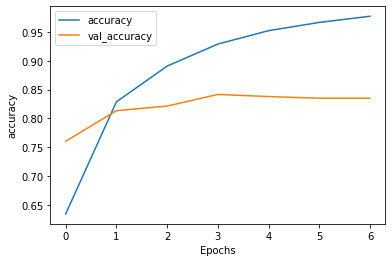

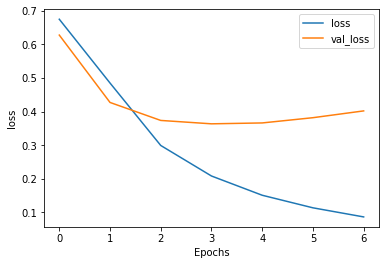

In [26]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

**Model 3**

In [27]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(64, 3, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 56, 32)            480000    
_________________________________________________________________
conv1d (Conv1D)              (None, 54, 64)            6208      
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 487,265
Trainable params: 487,265
Non-trainable params: 0
_________________________________________________________________


In [28]:
model3.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [29]:
num_epochs = 20
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history3 = model3.fit(train_sentences, train_labels, epochs=num_epochs, callbacks=[callback],validation_data=(validation_sentences, validation_labels), verbose=2)

Train on 8529 samples, validate on 2133 samples
Epoch 1/20
8529/8529 - 7s - loss: 0.5811 - accuracy: 0.6675 - val_loss: 0.4121 - val_accuracy: 0.7914
Epoch 2/20
8529/8529 - 6s - loss: 0.2894 - accuracy: 0.8789 - val_loss: 0.3919 - val_accuracy: 0.8172
Epoch 3/20
8529/8529 - 6s - loss: 0.1190 - accuracy: 0.9621 - val_loss: 0.4660 - val_accuracy: 0.8265
Epoch 4/20
8529/8529 - 5s - loss: 0.0349 - accuracy: 0.9921 - val_loss: 0.6012 - val_accuracy: 0.8172
Epoch 5/20
8529/8529 - 6s - loss: 0.0104 - accuracy: 0.9989 - val_loss: 0.6894 - val_accuracy: 0.8120


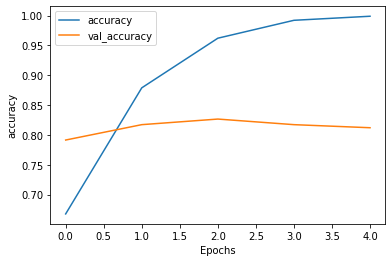

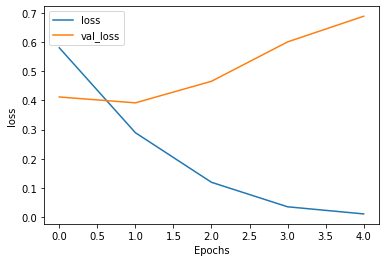

In [30]:
plot_graphs(history3, "accuracy")
plot_graphs(history3, "loss")

### Step 6: Save the model

In [31]:
# Save the model
model.save('./model', save_format="tf")
print('export saved model.')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./model\assets
export saved model.
